In [ ]:
# import os
# import json
# import whisper
# import torch
# import multiprocessing as mp

# try:
#     mp.set_start_method('spawn')
# except RuntimeError:
#     pass

# folder_path = "/home/pachen/dataset/Audio2Caption_Demo/alice's group/Nov 23, 2021 1026 AM"
# audio_folder = os.path.join(folder_path, "cut_audio_segments_flac")
# original_json_path = os.path.join(folder_path, "GMT20211123-022650_Recording.json")

# with open(original_json_path, "r", encoding="utf-8") as f:
#     original_data = json.load(f)

# file_paths = [os.path.join(audio_folder, file) for file in os.listdir(audio_folder) if file.endswith(".flac")]

# num_gpus = torch.cuda.device_count()
# pool = mp.Pool(processes=num_gpus)

# def process_file(rank, file_paths):
#     device = f"cuda:{rank}"
#     torch.cuda.set_device(device)

#     model = whisper.load_model("large-v3", device=device)

#     for file_path in file_paths:
#         file_number = int(os.path.splitext(os.path.basename(file_path))[0])

#         # 加载音频文件
#         audio = whisper.load_audio(file_path)

#         # 调用 Whisper 模型进行推理
#         audio = whisper.pad_or_trim(audio)
#         mel = whisper.log_mel_spectrogram(audio).to(device)
#         _, decoded_options, _ = model.detect_language(mel)
#         result = model.transcribe(mel, language="cantonese", **decoded_options)

#         # 查找对应的原始字幕条目
#         original_entry = next((entry for entry in original_data if int(entry["id"]) == file_number), None)

#         if original_entry:
#             # 在原始字幕条目中添加 Whisper 的 ASR 结果
#             original_entry["whisper_sentence"] = result["text"]

# # 将文件路径平均分配到每个进程
# file_paths_per_process = [[] for _ in range(num_gpus)]
# for i, file_path in enumerate(file_paths):
#     file_paths_per_process[i % num_gpus].append(file_path)

# # 并行处理文件
# args = [(rank, paths) for rank, paths in enumerate(file_paths_per_process)]
# pool.starmap(process_file, args)

# # 关闭进程池
# pool.close()
# pool.join()

# # 将修改后的数据写入新的 JSON 文件
# output_json_path = os.path.join(folder_path, f"GMT20211123-022650_Recording_whisper.json")
# with open(output_json_path, "w", encoding="utf-8") as f:
#     json.dump(original_data, f, ensure_ascii=False, indent=4)

## 

根据多个文件计算CER，新的inference不用

In [12]:
import json

# 路径设置
original_json_path = '/home/pachen/dataset/Audio2Caption_Demo/alice\'s group/Nov 23, 2021 1026 AM/GMT20211123-022650_Recording.json'
whisper_json_path = '/home/pachen/dataset/ASR/output.json'

# 读取原始JSON文件
with open(original_json_path, 'r', encoding='utf-8') as file:
    original_data = json.load(file)

# 读取whisper JSON文件
with open(whisper_json_path, 'r', encoding='utf-8') as file:
    whisper_data = json.load(file)

# 更新原始数据
for item in original_data:
    # 获取ID，并转换为字符串格式，以匹配whisper JSON中的键
    item_id = str(item['id'])
    # 如果此ID在whisper数据中存在，则添加whisper字段
    if item_id in whisper_data:
        item['whisper'] = whisper_data[item_id]['text']

# 写回更新后的数据到一个新文件
new_json_path = original_json_path.replace('.json', '_with_whisper.json')
with open(new_json_path, 'w', encoding='utf-8') as file:
    json.dump(original_data, file, ensure_ascii=False, indent=4)

print(f'更新完成，新文件已保存至：{new_json_path}')


更新完成，新文件已保存至：/home/pachen/dataset/Audio2Caption_Demo/alice's group/Nov 23, 2021 1026 AM/GMT20211123-022650_Recording_with_whisper.json


计算CER

In [8]:
import json
import Levenshtein as lev
import re

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def calculate_cer(reference, hypothesis):
    distance = lev.distance(reference, hypothesis)
    max_len = max(len(reference), len(hypothesis))
    if max_len == 0:
        return 0
    return distance / max_len

def transform_and_calculate_metrics(json_path):
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    total_distance = 0
    total_reference_len = 0

    for item in data:
        reference = remove_punctuation(item.get('sentence', '')).replace(" ", "")
        hypothesis = remove_punctuation(item.get('whisper', '')).replace(" ", "")
        distance = lev.distance(reference, hypothesis)
        total_distance += distance
        total_reference_len += len(reference)
        item_cer = calculate_cer(reference, hypothesis) if len(reference) > 0 else 0
        item['cer'] = item_cer

    average_cer = total_distance / total_reference_len if total_reference_len > 0 else 0

    new_json_path = json_path.replace('.json', '_metrics.json')
    with open(new_json_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

    return average_cer

json_path = "/home/pachen/dataset/Audio2Caption_Demo/alice's group/Nov 23, 2021 1026 AM/GMT20211123-022650_Recording_with_whisper.json"
average_cer = transform_and_calculate_metrics(json_path)
print(f'Average CER: {average_cer}')


Average CER: 0.7922906513070448


总CER，仅计算中文字符

In [2]:
import json
import re
from Levenshtein import distance as levenshtein_distance

def clean_text(text):
    return "".join(re.findall(r'[\u4e00-\u9fff]', text))

def calculate_cer(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    total_ref_len = 0
    total_edit_distance = 0
    
    for item in data:
        ref_text = clean_text(item['sentence'])
        hyp_text = clean_text(item['whisper'])
        
        total_ref_len += len(ref_text)
        total_edit_distance += levenshtein_distance(ref_text, hyp_text)
    
    cer = total_edit_distance / total_ref_len if total_ref_len > 0 else 0
    return cer

if __name__ == "__main__":
    json_file_path = "/home/pachen/dataset/Audio2Caption_Demo/alice's group/Nov 23, 2021 1026 AM/GMT20211123-022650_Recording_30s_whisper.json"  # 更改为你的文件路径
    cer = calculate_cer(json_file_path)
    print(f"CER: {cer:.10f}")


CER: 0.6305530372


总CER，忽略所有标点和空格

In [7]:
import json
import re

def clean_text(text):
    return re.sub(r'[\s,.，。]', '', text)

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def calculate_cer(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    total_ref_len = 0
    total_edit_distance = 0
    
    for item in data:
        ref_text = clean_text(item['sentence'])
        hyp_text = clean_text(item['whisper'])
        
        total_ref_len += len(ref_text)
        total_edit_distance += levenshtein_distance(ref_text, hyp_text)
    
    cer = total_edit_distance / total_ref_len if total_ref_len > 0 else 0
    return cer

if __name__ == "__main__":
    json_file_path = "/home/pachen/dataset/Audio2Caption_Demo/alice\'s group/Nov 23, 2021 1026 AM/GMT20211123-022650_Recording_30s_whisper.json"
    cer = calculate_cer(json_file_path)
    print(f"CER: {cer:.10f}")


CER: 0.6310473153


CER与音频中文字字数的关系

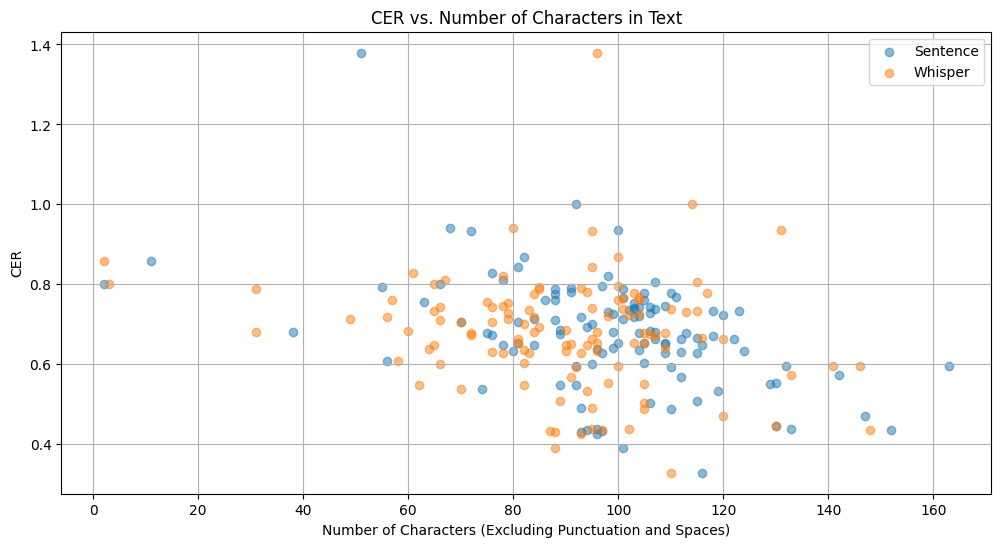

In [4]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np

# 移除文本中的标点符号和空格
def clean_text(text):
    return re.sub(r'[\s。？！，、；：“”‘’（）《》【】…—]', '', text)

# 计算文本的字数
def count_characters(text):
    return len(clean_text(text))

# 读取 JSON 数据并计算每个记录的 CER 与字数之间的关系
def analyze_cer_vs_characters(file_path):
    cer_list = []
    sentence_char_counts = []
    whisper_char_counts = []

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        # for entry in data['results']:
        for entry in data:
            cer = entry['cer']
            sentence_chars = count_characters(entry['sentence'])
            whisper_chars = count_characters(entry['whisper'])

            cer_list.append(cer)
            sentence_char_counts.append(sentence_chars)
            whisper_char_counts.append(whisper_chars)

    return cer_list, sentence_char_counts, whisper_char_counts

# 绘制 CER 与字数的关系图
def plot_cer_vs_characters(cer_list, sentence_char_counts, whisper_char_counts):
    plt.figure(figsize=(12, 6))

    # 绘制 sentence 字数与 CER 的关系
    plt.scatter(sentence_char_counts, cer_list, alpha=0.5, label='Sentence')
    # 绘制 whisper 字数与 CER 的关系
    plt.scatter(whisper_char_counts, cer_list, alpha=0.5, label='Whisper')
    
    plt.xlabel('Number of Characters (Excluding Punctuation and Spaces)')
    plt.ylabel('CER')
    plt.title('CER vs. Number of Characters in Text')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    file_path = "/home/pachen/dataset/ASR/GMT20211123-022650_Recording_30s_whisper.json"
    cer_list, sentence_char_counts, whisper_char_counts = analyze_cer_vs_characters(file_path)
    plot_cer_vs_characters(cer_list, sentence_char_counts, whisper_char_counts)
